# BERT - Out of the Box

In this notebook, we will test the performance of an out-of-the-box BERT model on CommonsenseQA. I follow the tutorial here: https://github.com/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb

I've implemented the Hugginface transformers library. 

I referred to the Commonsense QA repo and code to understand how the authors of this work establiahsed their baseline using BERT. This is the link to their code: https://github.com/jonathanherzig/commonsenseqa/blob/master/bert/run_commonsense_qa.py

From this repo (README): https://github.com/jonathanherzig/commonsenseqa

Their work is far more advanced and complicated than maybe what I want to do at this time. But I refer to their work to understand the set up.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
# import torch
import transformers as ppb
import warnings

import json
from pandas.io.json import json_normalize
warnings.filterwarnings('ignore')


from transformers import BertTokenizer, TFBertModel
# BertModel, \
# DistilBertModel, DistilBertTokenizer, \
# AutoTokenizer, AutoModelWithLMHead


# from tensorflow.keras.preprocessing.sequence import pad_sequences
from IPython.display import Image 
import tensorflow as tf
from tensorflow import keras

from datetime import datetime

import pickle

In [2]:
print(tf.__version__) 

2.3.1


In [3]:
print("Num GPUs Available: ", 
      len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [4]:
print("Num CPUs Available: ",
      len(tf.config.experimental.list_physical_devices('CPU')))


Num CPUs Available:  1


## Import dataset

It's in the dataset folder.

In [5]:
file = '../dataset/train_rand_split.jsonl'

def load_data(file):

    lines = []
    with open(file, 'rb') as json_file:
        for json_line in json_file:
            lines.append(json.loads(json_line))
        data = json_normalize(lines)
        data.columns = data.columns.map(lambda x: x.split(".")[-1])
    return data

train = load_data(file)
dev = load_data('../dataset/dev_rand_split.jsonl')
train.head()

,answerKey,id,question_concept,choices,stem
0,A,075e483d21c29a511267ef62bedc0461,punishing,"[{'label': 'A', 'text': 'ignore'}, {'label': '...",The sanctions against the school were a punish...
1,B,61fe6e879ff18686d7552425a36344c8,people,"[{'label': 'A', 'text': 'race track'}, {'label...",Sammy wanted to go to where the people were. ...
2,A,4c1cb0e95b99f72d55c068ba0255c54d,choker,"[{'label': 'A', 'text': 'jewelry store'}, {'la...",To locate a choker not located in a jewelry bo...
3,D,02e821a3e53cb320790950aab4489e85,highway,"[{'label': 'A', 'text': 'united states'}, {'la...",Google Maps and other highway and street GPS s...
4,C,23505889b94e880c3e89cff4ba119860,fox,"[{'label': 'A', 'text': 'pretty flowers.'}, {'...","The fox walked from the city into the forest, ..."


# BERT base model (cased)

From: https://huggingface.co/bert-base-cased

> Pretrained model on English language using a masked language modeling (MLM) objective. It was introduced in this paper and first released in this repository. 
> 
> Disclaimer: The team releasing BERT did not write a model card for this model so this model card has been written by the Hugging Face team.

In [6]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

lab_order = {"A": 0, "B":1, "C":2, "D":3, "E":4}

class InputExample(object):
    """A single multiple choice question."""
    # This class is adapted from https://github.com/jonathanherzig/commonsenseqa/blob/master/bert/run_commonsense_qa.py

    def __init__(
            self,
            qid,
            question,
            answer,
            label):
        """Construct an instance."""
        self.qid = qid
        self.question = question  # e.g., 'The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?'
        self.answer = answer      # e.g., "ignore" if choice label is A 
        self.label = label        # e.g., If correct answer, 1. Otherwise 0. 
        
    def __str__(self):
        return "QUESTION: {}\nANSWER  : {}\nLABEL   : {}".format(self.question, self.answer, self.label)
    
    
def create_example(row, choice_num):
    qid = row.id
    
    # Question: Just take it from stem 
    question = row.stem
    
    # Answer choice 
    label = int(row["answerKey"] == choice_num)  # If the answer key is equal to the answer choice number, mark 1 
    answer = row["choices"][lab_order[choice_num]]["text"]         # actual ans text 
    
    return InputExample(qid, question, answer, label) 
    
    
def process_examples(data):
    examples = []
    labels = []
    questions = []
    anscands = []
    
    
    for index, row in data.iterrows(): 
        for letter in lab_order.keys():
            example = create_example(row, letter)
            examples.append(example)
            
            questions.append(example.question)
            anscands.append(example.answer)
            labels.append(example.label)
            
            
        
    encoded_example = tokenizer(questions, anscands, 
                                            padding=True, 
                                            truncation=True, 
                                            return_tensors='tf')
            
    return examples, encoded_example, labels


Process dev and training data

In [7]:
dev_eg, dev_encoded_eg, dev_labs = process_examples(dev)
train_eg, train_encoded_eg, train_labs = process_examples(train)

In [8]:
type(train_encoded_eg)

transformers.tokenization_utils_base.BatchEncoding

In [9]:
len(train_encoded_eg)

3

In [10]:
type(train_encoded_eg["input_ids"])

tensorflow.python.framework.ops.EagerTensor

In [11]:
type(train_encoded_eg["input_ids"])

tensorflow.python.framework.ops.EagerTensor

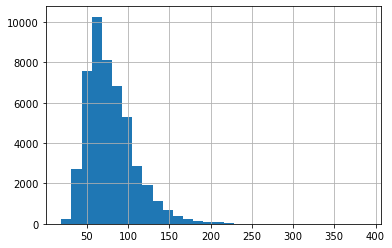

In [14]:
# get length of all the question + answer in the train set
seq_len = [len(i.question) + len(i.answer) for i in train_eg]

pd.Series(seq_len).hist(bins = 30)

In [15]:
max(seq_len)

388

Question: I dno't want to use 388 because too sparse. 

### Game plan

I'll be following the tutorial on: http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/, but for specifically commonsenseQA. Here are the steps from the tutorial.

1. Embed all sentences. Let's look at the output from the BERT model for our inputs. 
2. The tutorial says do a train/test split. We don't need this 'cause our data came separate.
3. Train the logistic regressio model using the training set. This is training on the output of BERT. I will need to create a FFNN to attach at the end of BERT. See what it comes back with. 
4. (Optional for now) For each question, pick the answer with the highest score. 
5. Then, evaluate against true answers. The evaluation metric will be % of questions with the correct answers out of all questions. 


#### Step 1: Embed all sentences. 

I've already formatted the CommonsenseQA inpts to be fed into the BERT model. Let's look at the output from the BERT model for our inputs. It should have a 768-long vector for each input token.

In [12]:
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [22]:
size = 100

bert_inputs_dev_tiny = {"input_ids": dev_encoded_eg["input_ids"][:size,:], \
                          "token_type_ids": dev_encoded_eg["token_type_ids"][:size,:], \
                          "attention_mask": dev_encoded_eg["attention_mask"][:size,:]}

bert_labs_dev_tiny = dev_labs[:size]


In [23]:
size = 100

bert_inputs_train_tiny = {"input_ids": train_encoded_eg["input_ids"][:size,:], \
                          "token_type_ids": train_encoded_eg["token_type_ids"][:size,:], \
                          "attention_mask": train_encoded_eg["attention_mask"][:size,:]}

bert_labs_train_tiny = train_labs[:size]


In [24]:
bert_model.summary()  # only works if tfbertmodel not pytorch

Model: "tf_bert_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Each example has 68 tokens for dev and 75 tokens for train 
# Each token yields a vector of 768 numbers after coming out
# of the bert model!

bert_out = bert_model(train_encoded_eg)#bert_inputs_train_tiny)

with open('oob_bert_output_768.pkl', 'wb') as file:
    pickle.dump(bert_out, file)


ResourceExhaustedError: OOM when allocating tensor with shape[48705,76,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ResourceGather]

In [ ]:
type(bert_out)

In [ ]:
bert_out[0].shape

Extract just the CLS token for all examples.

In [ ]:
features = bert_out[0][:,0,:]
features.shape

In [33]:
# Let's do a logistic regression. 

lr_clf = LogisticRegression()
lr_clf.fit(features, train_labs)

# filename = 'oob_bert_with_logisticregression.sav'
# pickle.dump(lr_clf, open(filename, 'wb'), encoding="UTF-8")

with open('oob_bert_with_logisticregression.pkl', 'wb') as file:
    pickle.dump(lr_clf, file)


In [25]:
lr_clf.score(features, train_encoded_eg)

0.95

In [26]:
dev_features = bert_model(dev_encoded_eg)[0][:,0,:]

In [27]:
lr_clf.score(dev_features, dev_labs)

0.76